In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

# Load datasets
satellite_df = pd.read_csv('combined_data_smote_10000_scaled_numeric.csv')
flood_risk_df = pd.read_csv('datasets/india_flood_risk/flood_risk_dataset_india.csv')

# Convert flood_risk_df target to numeric
flood_risk_df['is_flood'] = flood_risk_df['Flood Occurred'].astype(int)

# Normalize and standardize flood_risk_df numeric columns
numeric_cols = flood_risk_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
if 'Flood Occurred' in numeric_cols:
    numeric_cols.remove('Flood Occurred')
if 'is_flood' in numeric_cols:
    numeric_cols.remove('is_flood')

# Standardize and normalize
flood_risk_scaled_df = flood_risk_df.copy()
scaler = StandardScaler()
standardized_data = scaler.fit_transform(flood_risk_df[numeric_cols])
normalizer = MinMaxScaler()
normalized_data = normalizer.fit_transform(standardized_data)
flood_risk_scaled_df[numeric_cols] = normalized_data

# Handle categorical columns with one-hot encoding
categorical_cols = flood_risk_df.select_dtypes(include=['object']).columns.tolist()
if categorical_cols:
    flood_risk_scaled_df = pd.get_dummies(flood_risk_scaled_df, columns=categorical_cols, drop_first=True)

# Split both datasets into train/test sets
X_satellite = satellite_df.drop('is_flood', axis=1)
y_satellite = satellite_df['is_flood']
X_satellite_train, X_satellite_test, y_satellite_train, y_satellite_test = train_test_split(
    X_satellite, y_satellite, test_size=0.2, random_state=42, stratify=y_satellite)

X_flood_risk = flood_risk_scaled_df.drop(['Flood Occurred', 'is_flood'], axis=1)
y_flood_risk = flood_risk_scaled_df['is_flood']
X_flood_risk_train, X_flood_risk_test, y_flood_risk_train, y_flood_risk_test = train_test_split(
    X_flood_risk, y_flood_risk, test_size=0.2, random_state=42, stratify=y_flood_risk)

print(f"Satellite training data: {X_satellite_train.shape}, Satellite test data: {X_satellite_test.shape}")
print(f"Flood risk training data: {X_flood_risk_train.shape}, Flood risk test data: {X_flood_risk_test.shape}")

Satellite training data: (8000, 2), Satellite test data: (2000, 2)
Flood risk training data: (8000, 19), Flood risk test data: (2000, 19)


In [4]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Train models on satellite data
satellite_models = {
    'rf': RandomForestClassifier(n_estimators=100, random_state=42),
    'gb': GradientBoostingClassifier(random_state=42),
    'svm': SVC(probability=True, random_state=42)
}

for name, model in satellite_models.items():
    model.fit(X_satellite_train, y_satellite_train)
    print(f"Satellite {name} model accuracy: {accuracy_score(y_satellite_test, model.predict(X_satellite_test)):.4f}")

# Train models on flood risk data
flood_risk_models = {
    'rf': RandomForestClassifier(n_estimators=100, random_state=42),
    'gb': GradientBoostingClassifier(random_state=42),
    'lr': LogisticRegression(random_state=42, max_iter=1000)
}

for name, model in flood_risk_models.items():
    model.fit(X_flood_risk_train, y_flood_risk_train)
    print(f"Flood risk {name} model accuracy: {accuracy_score(y_flood_risk_test, model.predict(X_flood_risk_test)):.4f}")

Satellite rf model accuracy: 0.8995
Satellite gb model accuracy: 0.8205
Satellite svm model accuracy: 0.7735
Flood risk rf model accuracy: 0.5005
Flood risk gb model accuracy: 0.4990
Flood risk lr model accuracy: 0.4965


In [5]:
from sklearn.model_selection import KFold
from sklearn.base import clone

# Create meta-features using cross-validation to avoid overfitting
def create_meta_features(models, X, y, cv=5):
    meta_features = np.zeros((X.shape[0], len(models)))
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    
    for i, (name, model) in enumerate(models.items()):
        print(f"Creating meta-features for {name}...")
        meta_feature = np.zeros(X.shape[0])
        
        for train_idx, val_idx in kf.split(X):
            X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
            y_train_fold = y.iloc[train_idx]
            
            clone_model = clone(model)
            clone_model.fit(X_train_fold, y_train_fold)
            meta_feature[val_idx] = clone_model.predict_proba(X_val_fold)[:, 1]
        
        meta_features[:, i] = meta_feature
    
    return meta_features

# Generate meta-features for training data
satellite_meta_train = create_meta_features(satellite_models, X_satellite_train, y_satellite_train)
flood_risk_meta_train = create_meta_features(flood_risk_models, X_flood_risk_train, y_flood_risk_train)

# Create meta-features for test data (using trained models)
satellite_meta_test = np.zeros((X_satellite_test.shape[0], len(satellite_models)))
for i, (name, model) in enumerate(satellite_models.items()):
    satellite_meta_test[:, i] = model.predict_proba(X_satellite_test)[:, 1]

flood_risk_meta_test = np.zeros((X_flood_risk_test.shape[0], len(flood_risk_models)))
for i, (name, model) in enumerate(flood_risk_models.items()):
    flood_risk_meta_test[:, i] = model.predict_proba(X_flood_risk_test)[:, 1]

Creating meta-features for rf...
Creating meta-features for gb...
Creating meta-features for svm...
Creating meta-features for rf...
Creating meta-features for gb...
Creating meta-features for lr...


Flood risk class distribution: 1    0.5057
0    0.4943
Name: is_flood, dtype: float64
Top correlated features:
Humidity (%)             0.027754
Land Cover_Water Body    0.026110
Temperature (°C)         0.015771
Longitude                0.015008
Soil Type_Loam           0.014699
Historical Floods        0.012030
Land Cover_Desert        0.010393
Soil Type_Silt           0.010243
Land Cover_Urban         0.009591
Soil Type_Sandy          0.007497
dtype: float64


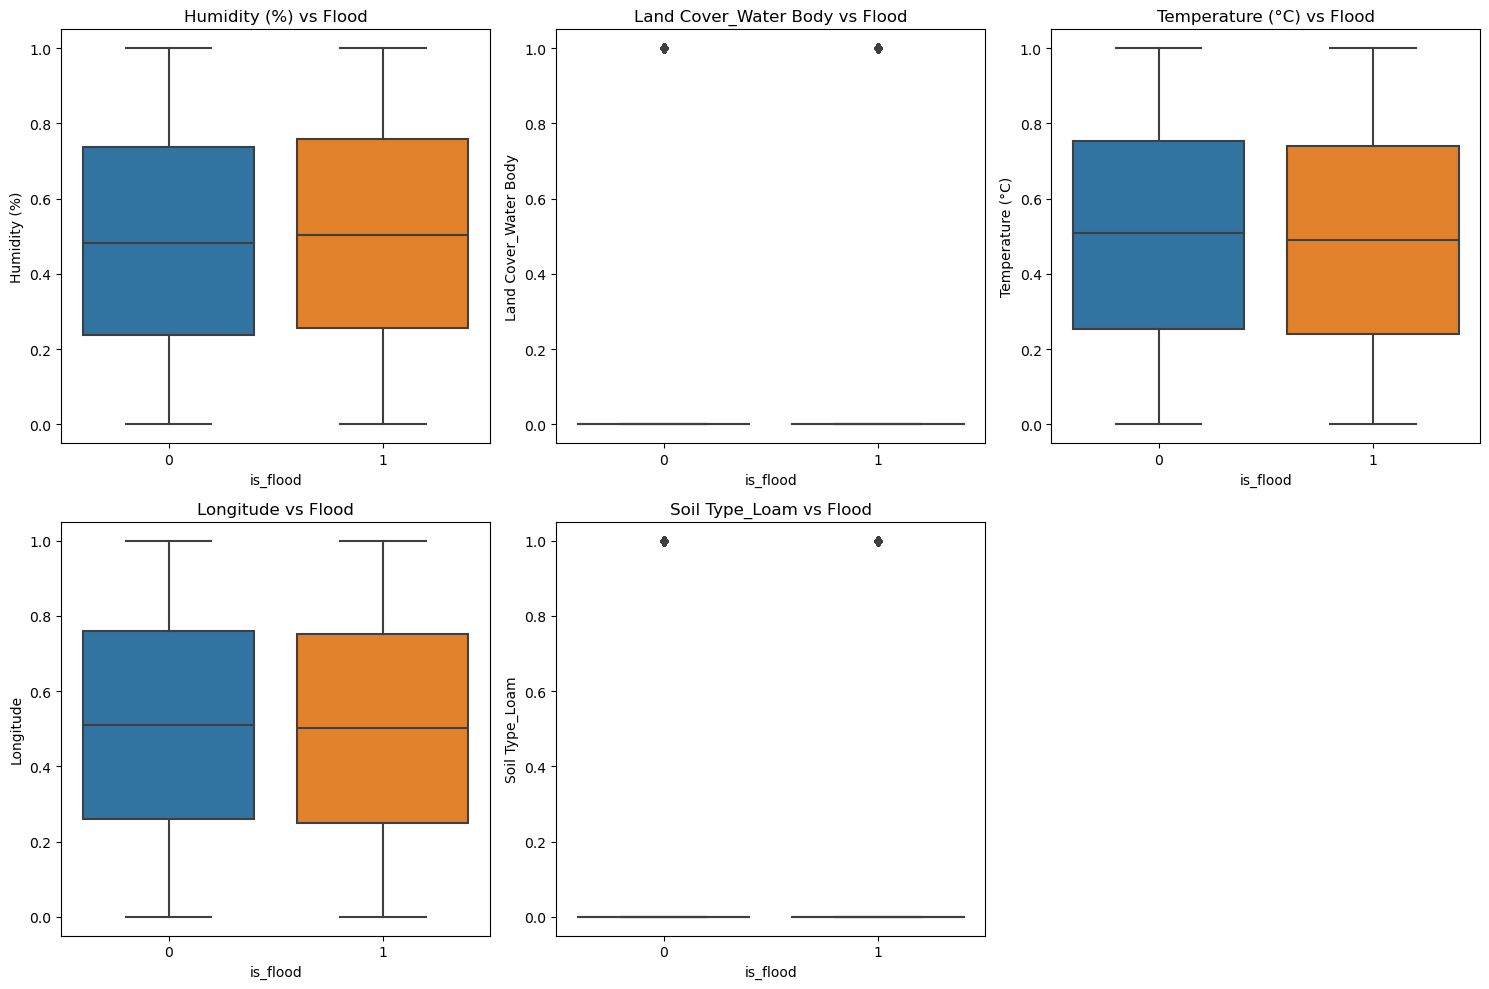

In [6]:
# Check class distribution
print("Flood risk class distribution:", y_flood_risk.value_counts(normalize=True))

# Check feature correlations with target
correlation = pd.DataFrame(X_flood_risk).corrwith(y_flood_risk)
print("Top correlated features:")
print(correlation.abs().sort_values(ascending=False).head(10))

# Visualize some key features against the target
plt.figure(figsize=(15, 10))
for i, feature in enumerate(correlation.abs().sort_values(ascending=False).head(5).index):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x=y_flood_risk, y=X_flood_risk[feature])
    plt.title(f"{feature} vs Flood")
plt.tight_layout()
plt.show()

In [7]:
#drop 
flood_risk_df.columns

Index(['Latitude', 'Longitude', 'Rainfall (mm)', 'Temperature (°C)',
       'Humidity (%)', 'River Discharge (m³/s)', 'Water Level (m)',
       'Elevation (m)', 'Land Cover', 'Soil Type', 'Population Density',
       'Infrastructure', 'Historical Floods', 'Flood Occurred', 'is_flood'],
      dtype='object')